In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

from scipy.spatial.distance import pdist, squareform

# Load data

In [2]:
nanostring_dir = Path().resolve() / "/project/BDShackathon/data/processed_CosMx_data-fixed_images/"
sample_dir = nanostring_dir / "HNSCCBottom"

adata_original = sq.read.nanostring(
    path=sample_dir,
    counts_file="HNSCCBottom_exprMat_file.csv",
    meta_file="HNSCCBottom_metadata_file.csv",
    fov_file="HNSCCBottom_fov_positions_file_adjusted.csv"
)

/home/ybw8gh/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
# cell type labels
cell_type_labels = pd.read_csv('aud_predicted.csv')
cell_type_labels = cell_type_labels[['Cell', 'PredictedID']]
cell_type_labels = cell_type_labels.set_index('Cell')
cell_type_labels

# QC

In [ ]:
# get control probes + calculate QC metrics
adata.var["NegativeCtrl"] = adata.var_names.str.startswith("Negative")
sc.pp.calculate_qc_metrics(adata, qc_vars=["NegativeCtrl"], inplace=True)

In [ ]:
# get control probes + calculate QC metrics
adata.var["SystemCtrl"] = adata.var_names.str.startswith("SystemControl")
sc.pp.calculate_qc_metrics(adata, qc_vars=["SystemCtrl"], inplace=True)

In [ ]:
import pandas as pd

pd.set_option("display.max_columns", None)

In [ ]:
# % of transcripts that are negative controls
adata.obs["total_counts_NegativeCtrl"].sum() / adata.obs["total_counts"].sum() * 100

In [ ]:
# % of transcripts that are system controls
adata.obs["total_counts_SystemCtrl"].sum() / adata.obs["total_counts"].sum() * 100

In [ ]:
# plot transcript distributions
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)

axs[2].set_title("Transcripts per FOV")
sns.histplot(
    adata.obs.groupby("fov").sum()["total_counts"],
    kde=False,
    ax=axs[2],
)

In [ ]:
# plot negative control transcript distributions
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].set_title("Total negative control transcripts per cell")
sns.histplot(
    adata.obs["total_counts_NegativeCtrl"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Transcripts per FOV")
sns.histplot(
    adata.obs.groupby("fov").sum()["total_counts_NegativeCtrl"],
    kde=False,
    ax=axs[1],
)

In [ ]:
# plot number of cells with gene expressed to identify outliers cutoff
n_cells_by_counts = list(adata.var.T.loc['n_cells_by_counts'].values)
sorted_n_cells_by_counts = sorted(n_cells_by_counts, reverse=True)
plt.bar(range(len(sorted_n_cells_by_counts)), sorted_n_cells_by_counts)
plt.title("Number of cells with gene expressed")
plt.xlabel('Random gene ID')
plt.ylabel("Number of cells")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("PanCK")
sns.histplot(
    adata.obs["Mean.PanCK"],
    kde=False,
    ax=axs[0],
)
# axs[0].set_xlim(0,10)

axs[1].set_title("Max_PanCK")
sns.histplot(
    adata.obs["Max.PanCK"],
    kde=False,
    ax=axs[1],
)
# axs[1].set_xlim(0,10)

axs[2].set_title("CD68_CK8_18")
sns.histplot(
    adata.obs["Mean.CD68_CK8_18"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("CD45")
sns.histplot(
    adata.obs["Mean.CD45"],
    kde=False,
    ax=axs[3],
)



In [ ]:
# Filter cells w/ low gene counts and genes w/ low cell counts
sc.pp.filter_cells(adata, min_counts=50)
sc.pp.filter_genes(adata, min_cells=400)

In [ ]:
# Pre-process data for visualization
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)    # normalize each cell's gene counts by each cell's total, so they're comparable between cells
sc.pp.log1p(adata)    # log-transform before PCA
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

# Visualize annotation on UMAP and spatial coordinates

Below we see that most cells have similar numbers of total gene counts and numbers of genes with at least one count. The Leiden clustering shows that there are 21 clusters of cells by their gene expression.

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

In [ ]:
sq.pl.spatial_scatter(adata, # load it per the tutorial
                      library_id='2', # Pick a FOV
                      library_key='fov', 
                      seg_cell_id='seg_cell_ID',
                      color='Mean.PanCK', # Pick a gene or feature of interest to colormap ontop
                      size=60, # The size of the plotted cell point
                     )

# Neighbor analysis

In [4]:
# load data w/ metadata annotations
adata = sc.read_h5ad('final_with_umap_and_images.h5ad')

In [5]:
# custom algorithm to calculate intercellular distances
fov_ids = list(set(adata.obs['fov'].values))    # set of FOV ids (1-158)
fov_pairwise_dists = {}
for fov_id in fov_ids:    # iterate through FOVs and calculate pairwise distance matrices
    cell_ids = adata.obs[adata.obs['fov'] == fov_id].index.to_list()    # IDs of cells in FOV
    if len(cell_ids) < 10:
        continue    # skip FOVs with too few cells
    cell_coords = adata.obs.loc[cell_ids][['CenterX_global_px', 'CenterY_global_px']]
    distances = pdist(cell_coords[['CenterX_global_px', 'CenterY_global_px']].values, metric='euclidean')
    dist_matrix = squareform(distances)
    distance_df = pd.DataFrame(dist_matrix, columns=cell_ids, index=cell_ids)
    # np.fill_diagonal(distance_df.values, 1e20)
    fov_pairwise_dists[fov_id] = distance_df

In [6]:
nearest_neighbors = {}
num_nearest_neighbors = 5    # neighborhood size to average over (self-inclusive)
for fov_id, dist_df in fov_pairwise_dists.items():
    for cell_id in dist_df.index:
        # Sort distances for the current cell
        sorted_distances = dist_df.loc[cell_id].sort_values()
        # Exclude the cell itself (closest neighbor is always the cell itself)
        neighbors = sorted_distances.index[1:num_nearest_neighbors+1].tolist()
        neighbor_distances = sorted_distances[1:num_nearest_neighbors+1].tolist()
        nearest_neighbors[cell_id] = [neighbors, neighbor_distances]

In [7]:
def weighted_average(neighbor_mean_panck, neighbor_distances):
    total_weights = 0
    avg = 0
    for i in range(len(neighbor_mean_panck)):
        total_weights += 1/neighbor_distances[i]
        avg += 1/neighbor_distances[i] * neighbor_mean_panck[i]
    return avg/total_weights

In [8]:
avg_pan_ck = {}
for cell_id, neighbor_info in nearest_neighbors.items():
    neighbor_ids, neighbor_distances = neighbor_info
    neighbor_mean_panck = list(adata.obs['Mean.PanCK'][neighbor_ids].values)
    avg_pan_ck[cell_id] = weighted_average(neighbor_mean_panck, neighbor_distances)

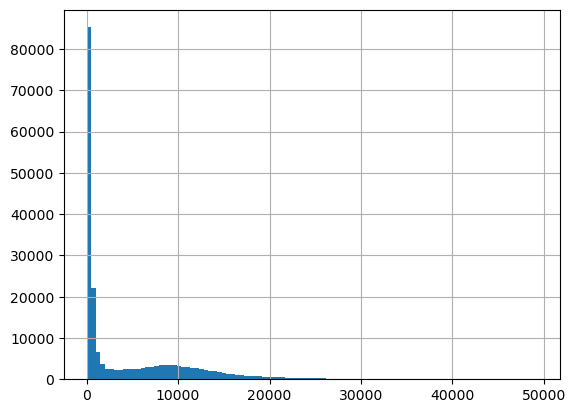

In [9]:
# distribution of averaged pan-CK values
plt.hist(list(avg_pan_ck.values()), bins=100)  # You can adjust the number of bins as needed
plt.grid(True)
plt.show()

In [10]:
adata.obs['Neighborhood.PanCK'] = adata.obs.index.map(avg_pan_ck)

## Images not working, TBD

Merging the two databases somehow broke the images.

In [ ]:
id = '55'

sq.pl.spatial_scatter(adata, # load it per the tutorial
                      library_id=id, # Pick a FOV
                      library_key='fov', 
                      seg_cell_id='seg_cell_ID',
                      color='Neighborhood.PanCK', # Pick a gene or feature of interest to colormap ontop
                      colorbar=False,
                      title='',
                      size=100, # The size of the plotted cell point
                      vmax=5000
                     )
plt.axis('off')
sq.pl.spatial_scatter(adata, # load it per the tutorial
                      library_id=id, # Pick a FOV
                      library_key='fov', 
                      seg_cell_id='seg_cell_ID',
                      color='Mean.PanCK', # Pick a gene or feature of interest to colormap ontop
                      colorbar=False,
                      title='',
                      size=100, # The size of the plotted cell point
                      vmax=5000
                     )
plt.axis('off')

# Label cells as tumor-region or non-tumor-region

In [137]:
adata.obs.columns.to_list()

['Unnamed: 0',
 'nn_099cd252.594c.4313.bce1.c5a1e082e25c_1_cluster_cluster_607ea837.811f.4b1b.b2a8.8ac1d9ecce1e_1',
 'RNA_nbclust_10e16648.07fd.4570.b9cd.ffeb64f05a23_1_clusters',
 'RNA_nbclust_10e16648.07fd.4570.b9cd.ffeb64f05a23_1_posterior_probability',
 'cell',
 'nCount_RNA',
 'nFeature_RNA',
 'nCount_negprobes',
 'nFeature_negprobes',
 'nn_9770d99f.df8e.4c6e.a1b5.a5de32389097_1_cluster_cluster_baf6a9bd.cc2d.494e.bced.538ee6a3c751_1',
 'RNA_nbclust_0ad37c2b.edec.4d71.a066.07348a7c9f29_1_clusters',
 'RNA_nbclust_0ad37c2b.edec.4d71.a066.07348a7c9f29_1_posterior_probability',
 'fov',
 'Area',
 'AspectRatio',
 'Width',
 'Height',
 'Mean.PanCK',
 'Max.PanCK',
 'Mean.CD68_CK8_18',
 'Max.CD68_CK8_18',
 'Mean.CD298_B2M',
 'Max.CD298_B2M',
 'Mean.CD45',
 'Max.CD45',
 'Mean.DAPI',
 'Max.DAPI',
 'cell_id',
 'assay_type',
 'version',
 'Run_Tissue_name',
 'Panel',
 'cellSegmentationSetId',
 'cellSegmentationSetName',
 'slide_ID',
 'CenterX_global_px',
 'CenterY_global_px',
 'unassignedTranscrip

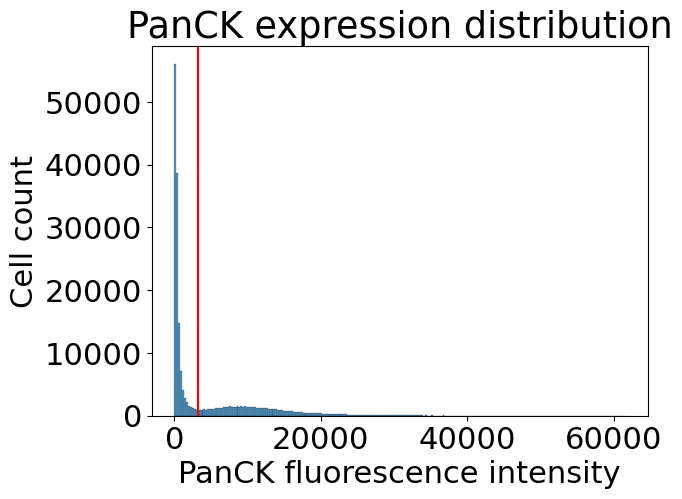

In [138]:
# identify empirical threshold
ax = sns.histplot(
    adata.obs["Mean.PanCK"],
    kde=False,
)
ax.set(title='PanCK expression distribution', xlabel='PanCK fluorescence intensity', ylabel='Cell count')
plt.axvline(3300, color='r')

In [115]:
adata.obs['Tumor_region'] = adata.obs['Neighborhood.PanCK'] >= 3300/4

In [ ]:
for id in fov_ids:
    sq.pl.spatial_scatter(adata, # load it per the tutorial
                          library_id=id, # Pick a FOV
                          library_key='fov', 
                          seg_cell_id='seg_cell_ID',
                          color='Tumor_region', # Pick a gene or feature of interest to colormap ontop
                          size=100, # The size of the plotted cell point
                         )
    plt.savefig('fov_' + id + '_tumor_region')

    sq.pl.spatial_scatter(adata, # load it per the tutorial
                          library_id=id, # Pick a FOV
                          library_key='fov', 
                          seg_cell_id='seg_cell_ID',
                          color='Mean.PanCK', # Pick a gene or feature of interest to colormap ontop
                          size=100, # The size of the plotted cell point
                          vmax=4250
                         )
    plt.savefig('fov_' + id + '_mean_panCK')

# Stitch FOVs into punchout images

In [ ]:
sq.pl.spatial_scatter(adata, # load it per the tutorial
                      library_id='1', # Pick a FOV
                      library_key='fov', 
                      seg_cell_id='seg_cell_ID',
                      color='Mean.PanCK', # Pick a gene or feature of interest to colormap ontop
                      colorbar=False,
                      title='',
                      size=100, # The size of the plotted cell point
                      vmax=5000
                     )

In [ ]:
for id in ['1']:
    sq.pl.spatial_scatter(adata, # load it per the tutorial
                          library_id=id, # Pick a FOV
                          library_key='fov', 
                          seg_cell_id='seg_cell_ID',
                          color='Tumor_region', # Pick a gene or feature of interest to colormap ontop
                          colorbar=False,
                          title='',
                          size=100, # The size of the plotted cell point
                          vmax=5000
                         )
    plt.axis('off')
    plt.legend('', frameon=False)
    # plt.savefig('no_axes/fov_' + id + '_tumor_region', bbox_inches='tight', pad_inches=0)

    sq.pl.spatial_scatter(adata, # load it per the tutorial
                          library_id=id, # Pick a FOV
                          library_key='fov', 
                          seg_cell_id='seg_cell_ID',
                          color='Mean.PanCK', # Pick a gene or feature of interest to colormap ontop
                          colorbar=False,
                          title='',
                          size=100, # The size of the plotted cell point
                          vmax=5000
                         )
    plt.axis('off')
    plt.show()
    # plt.savefig('no_axes/fov_' + id + '_mean_panCK', bbox_inches='tight', pad_inches=0)

In [ ]:
from PIL import Image

# List of file paths for your 9 PNG files (replace with your actual file paths)
file_paths = [
    'no_axes/fov_1_tumor_region.png',
    'no_axes/fov_2_tumor_region.png',
    'no_axes/fov_3_tumor_region.png',
    'no_axes/fov_4_tumor_region.png',
    'no_axes/fov_5_tumor_region.png',
    'no_axes/fov_6_tumor_region.png',
    'no_axes/fov_7_tumor_region.png',
    'no_axes/fov_8_tumor_region.png',
    'no_axes/fov_9_tumor_region.png'
]

# Load each image
images = [Image.open(file_path) for file_path in file_paths]

# Determine the dimensions of the final stitched image (3 rows x 3 columns)
num_rows, num_cols = 3, 3
max_width = max(img.width for img in images)
max_height = max(img.height for img in images)

# Create a new blank image to stitch the individual images onto
stitched_image = Image.new('RGBA', (max_width * num_cols, max_height * num_rows), (0, 0, 0, 0))

# Paste each image onto the stitched image
for row in range(num_rows):
    for col in range(num_cols):
        img_index = row * num_cols + col
        if img_index < len(images):
            x_offset = col * max_width
            y_offset = row * max_height
            stitched_image.paste(images[img_index], (x_offset, y_offset))

# Save the final stitched image
stitched_image.save('stitched_image.png')

print("Stitched image saved as 'stitched_image.png'")


# Inspect tumor/stroma ratio in edge/core/distal samples

In [116]:
edge_cells = adata.obs[adata.obs['Sample Location'] == 'E']
core_cells = adata.obs[adata.obs['Sample Location'] == 'C']
periph_cells = adata.obs[adata.obs['Sample Location'] == 'P']

In [132]:
edge_cells_tr_ratio = edge_cells['original_tumor_region'].sum() / (len(edge_cells) - edge_cells['original_tumor_region'].sum())
core_cells_tr_ratio = core_cells['original_tumor_region'].sum() / (len(core_cells) - core_cells['original_tumor_region'].sum())
periph_cells_tr_ratio = periph_cells['original_tumor_region'].sum() / (len(periph_cells) - periph_cells['original_tumor_region'].sum())
print(edge_cells_tr_ratio, core_cells_tr_ratio, periph_cells_tr_ratio)

0.45709199925051525 2.0507166482910693 0.0756803692617051


In [117]:
edge_cells_tr_ratio = edge_cells['Tumor_region'].sum() / (len(edge_cells) - edge_cells['Tumor_region'].sum())
core_cells_tr_ratio = core_cells['Tumor_region'].sum() / (len(core_cells) - core_cells['Tumor_region'].sum())
periph_cells_tr_ratio = periph_cells['Tumor_region'].sum() / (len(periph_cells) - periph_cells['Tumor_region'].sum())
print(edge_cells_tr_ratio, core_cells_tr_ratio, periph_cells_tr_ratio)

0.8878436608605935 5.400647698357622 0.1690424158140459


# Inspect tumor/stroma composition

Aggregated across all patients.

In [118]:
plt.rcParams.update({'font.size': 22})

## pre-neighbor smoothing

In [119]:
adata.obs['original_tumor_region'] = adata.obs['Mean.PanCK'] >= 3300

In [120]:
original_tumor_region_cells = adata.obs[adata.obs['original_tumor_region'] == True]
original_stromal_region_cells = adata.obs[adata.obs['original_tumor_region'] == False]

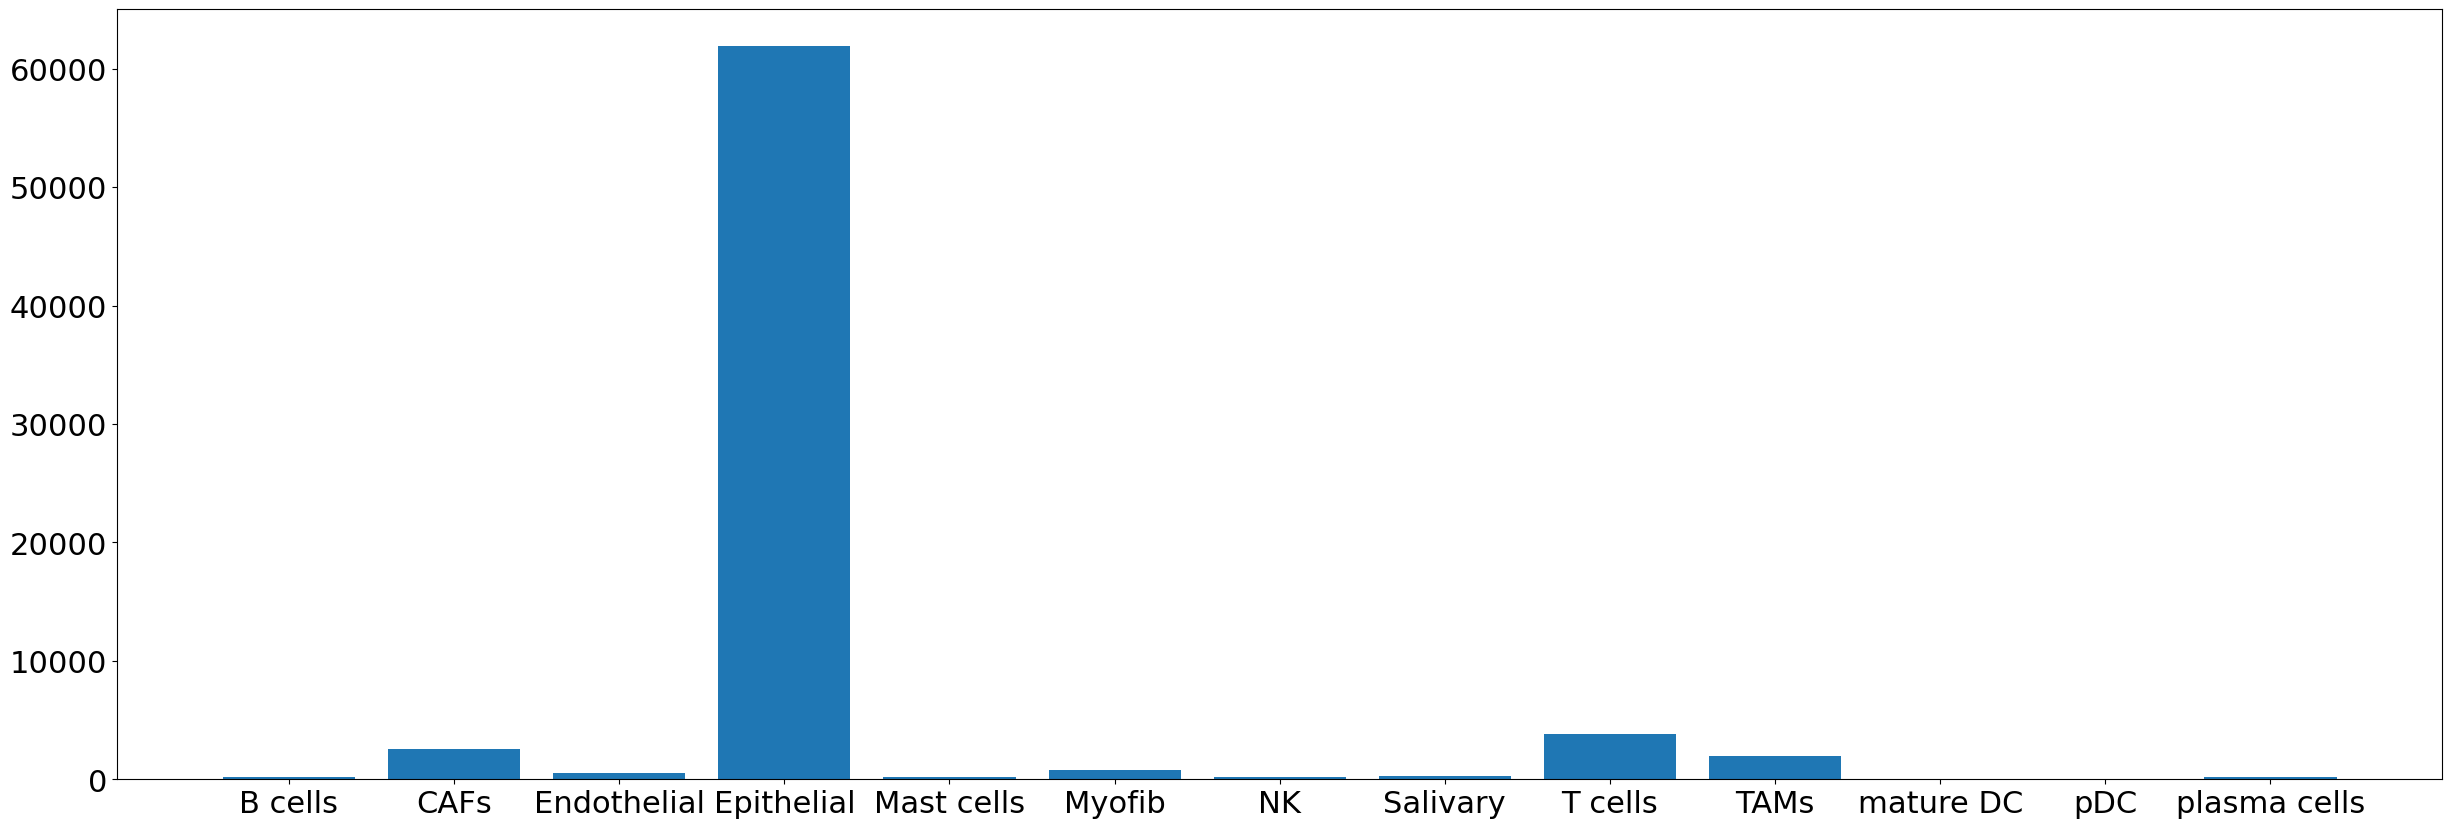

In [121]:
original_tumor_region_cell_types = original_tumor_region_cells['PredictedID']
keys, counts = np.unique(original_tumor_region_cell_types, return_counts=True)
plt.figure(figsize=(30,10))
plt.bar(keys, counts)
plt.show()

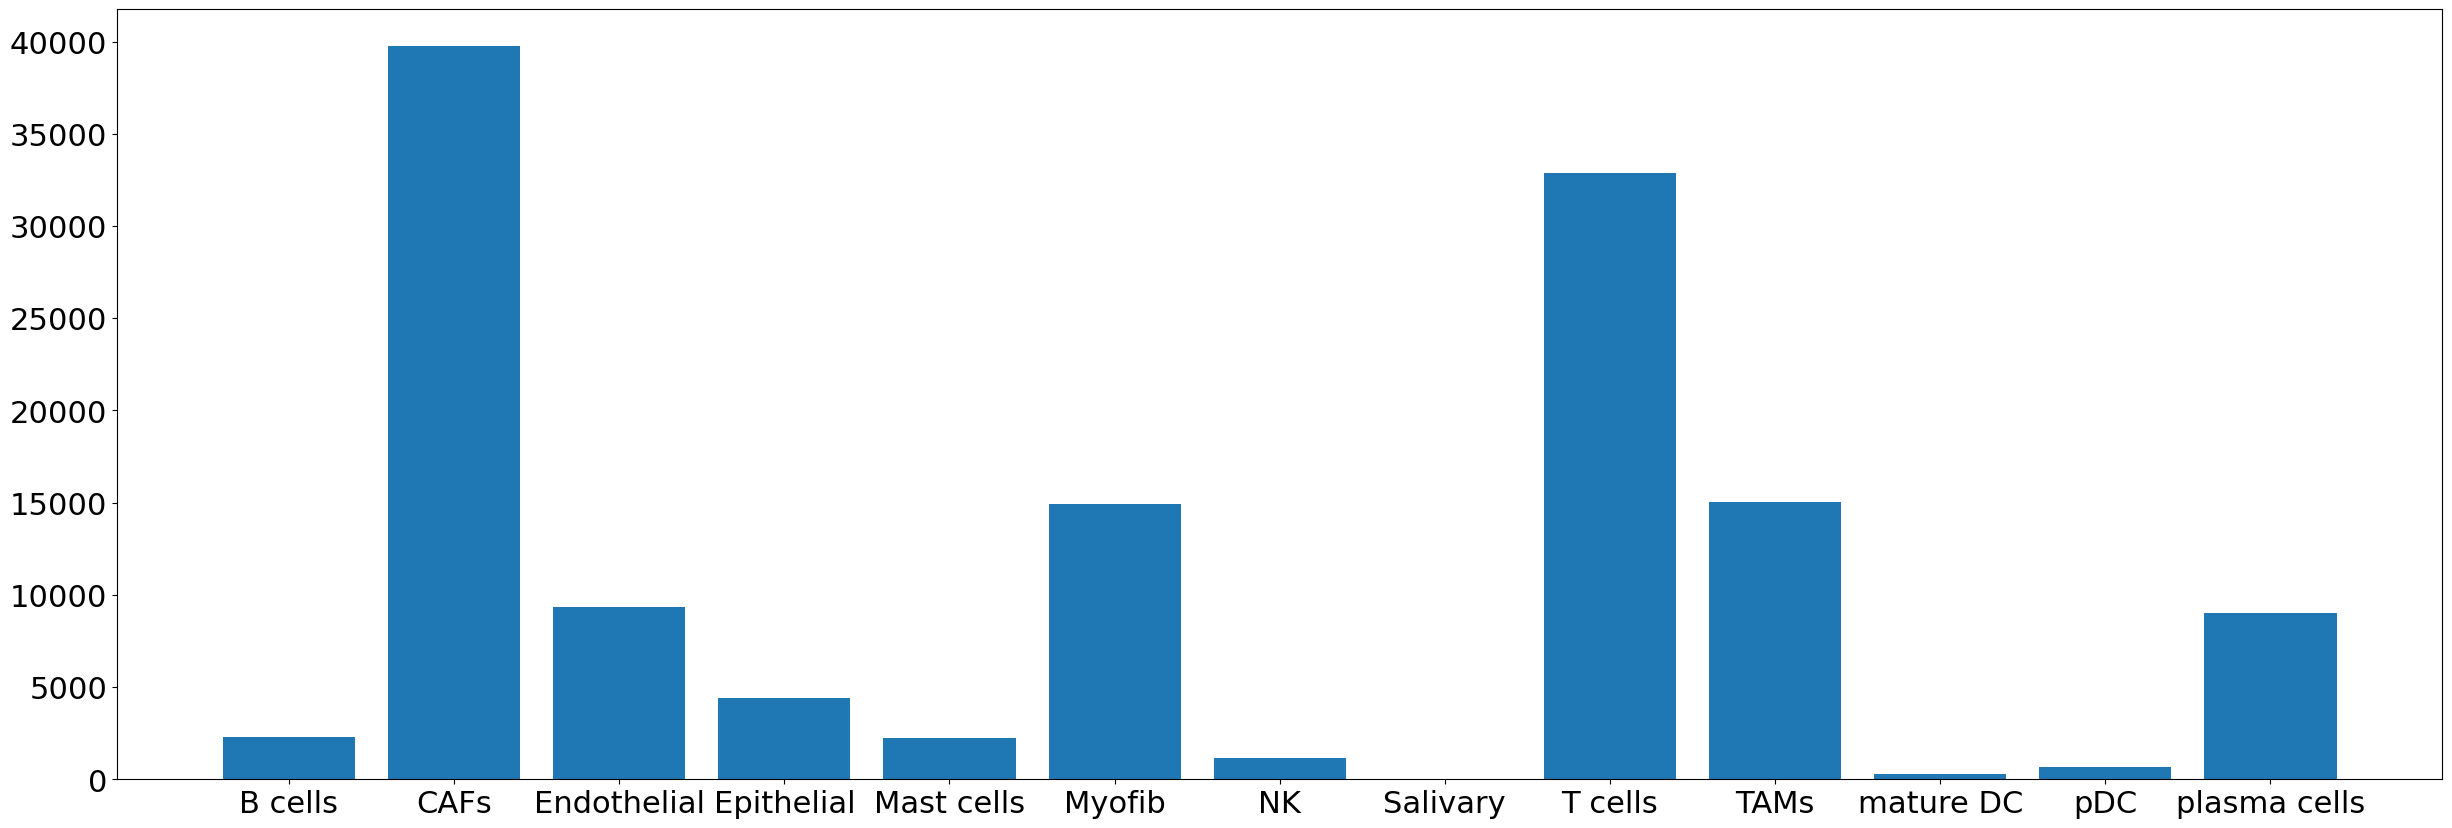

In [122]:
original_stromal_region_cell_types = original_stromal_region_cells['PredictedID']
keys, counts = np.unique(original_stromal_region_cell_types, return_counts=True)
plt.figure(figsize=(30,10))
plt.bar(keys, counts)
plt.show()

## post-neighbor smoothing

In [123]:
tumor_region_cells = adata.obs[adata.obs['Tumor_region'] == True]
stromal_region_cells = adata.obs[adata.obs['Tumor_region'] == False]

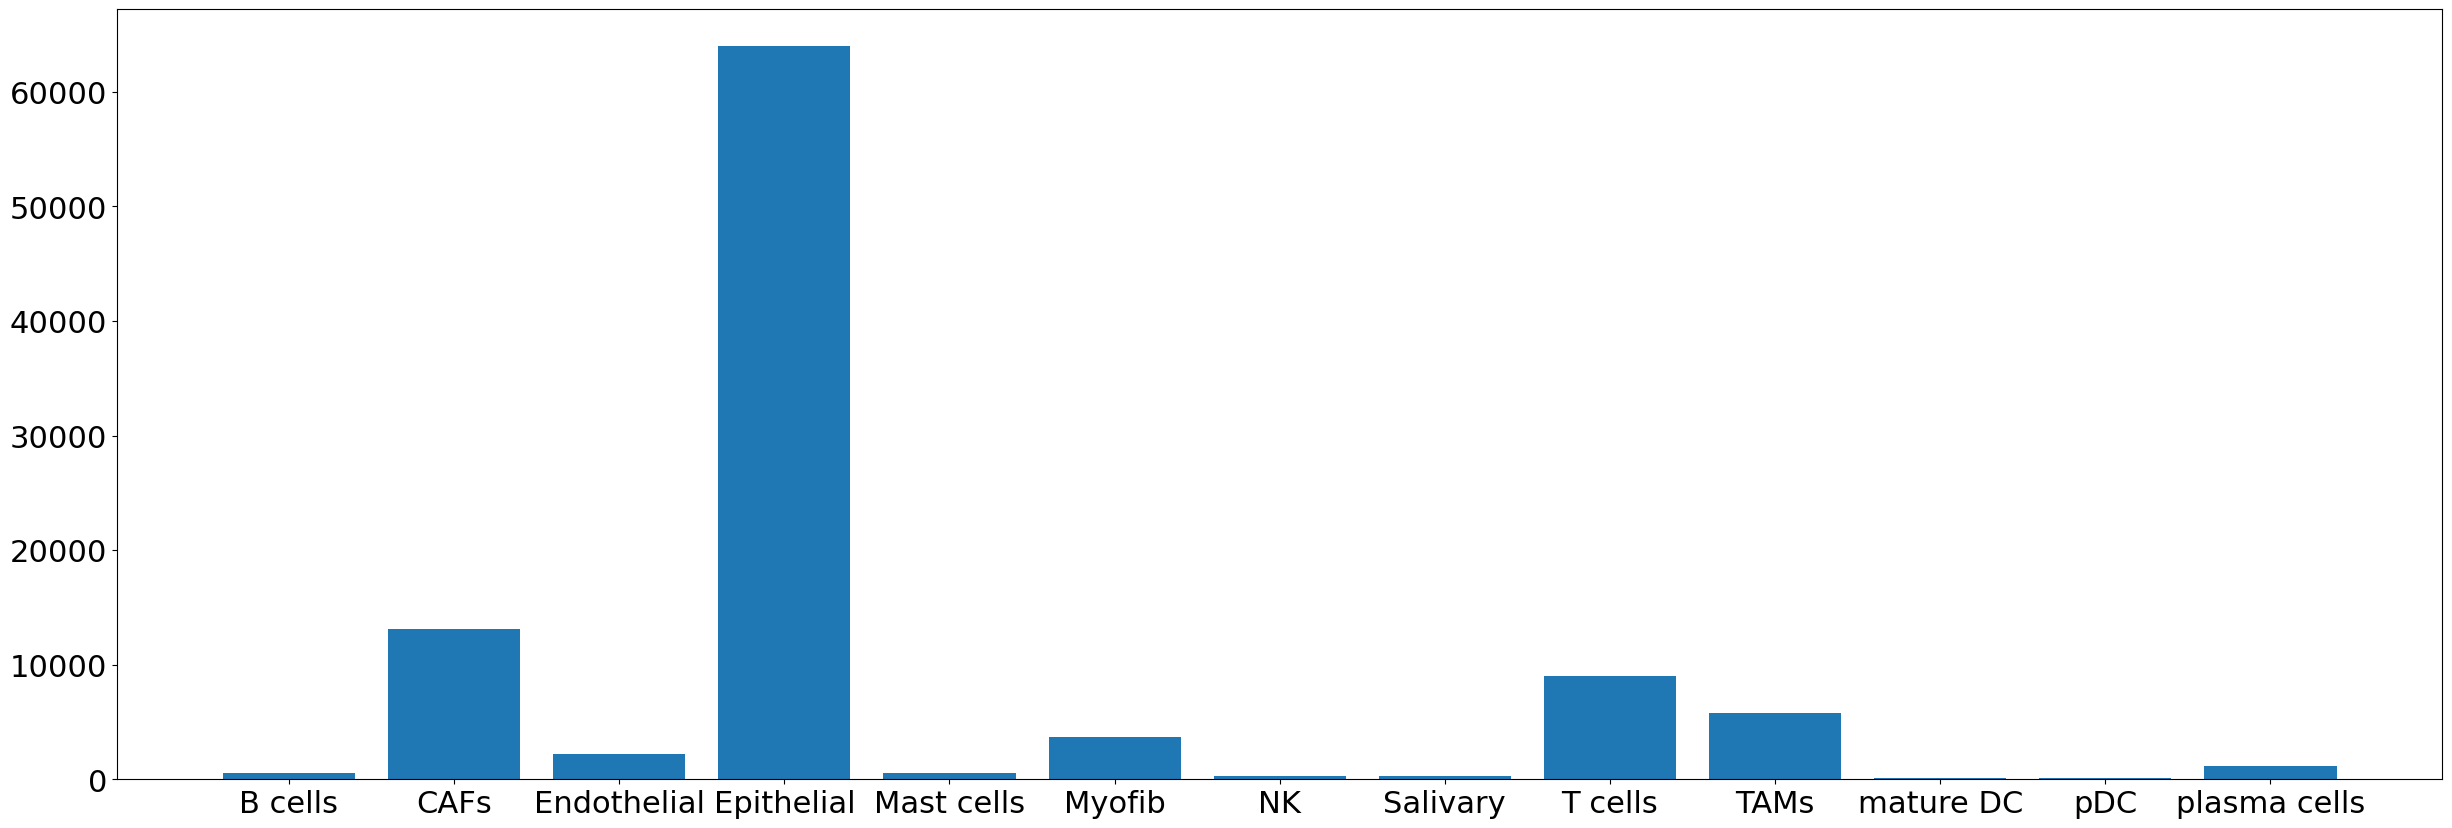

In [124]:
tumor_region_cell_types = tumor_region_cells['PredictedID']
keys, counts = np.unique(tumor_region_cell_types, return_counts=True)
plt.figure(figsize=(30,10))
plt.bar(keys, counts)
plt.show()

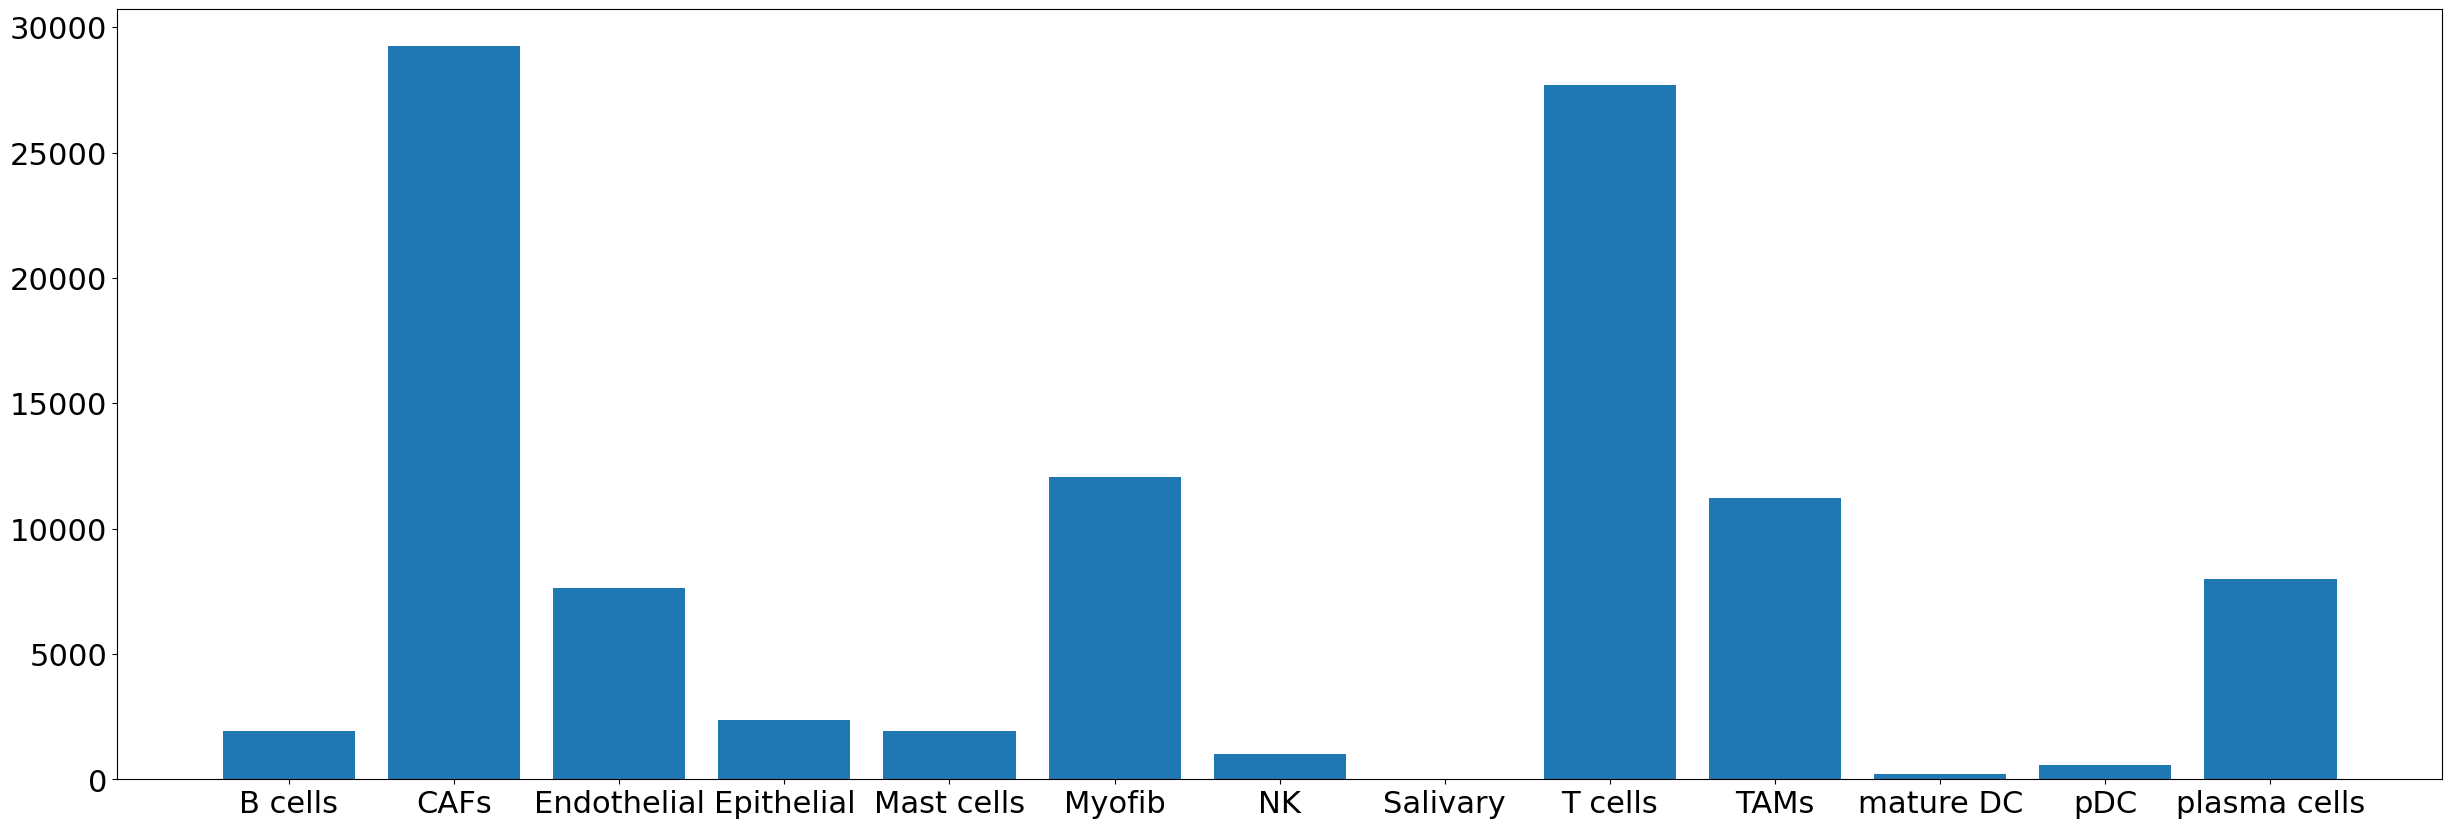

In [125]:
stromal_region_cell_types = stromal_region_cells['PredictedID']
keys, counts = np.unique(stromal_region_cell_types, return_counts=True)
plt.figure(figsize=(30,10))
plt.bar(keys, counts)
plt.show()

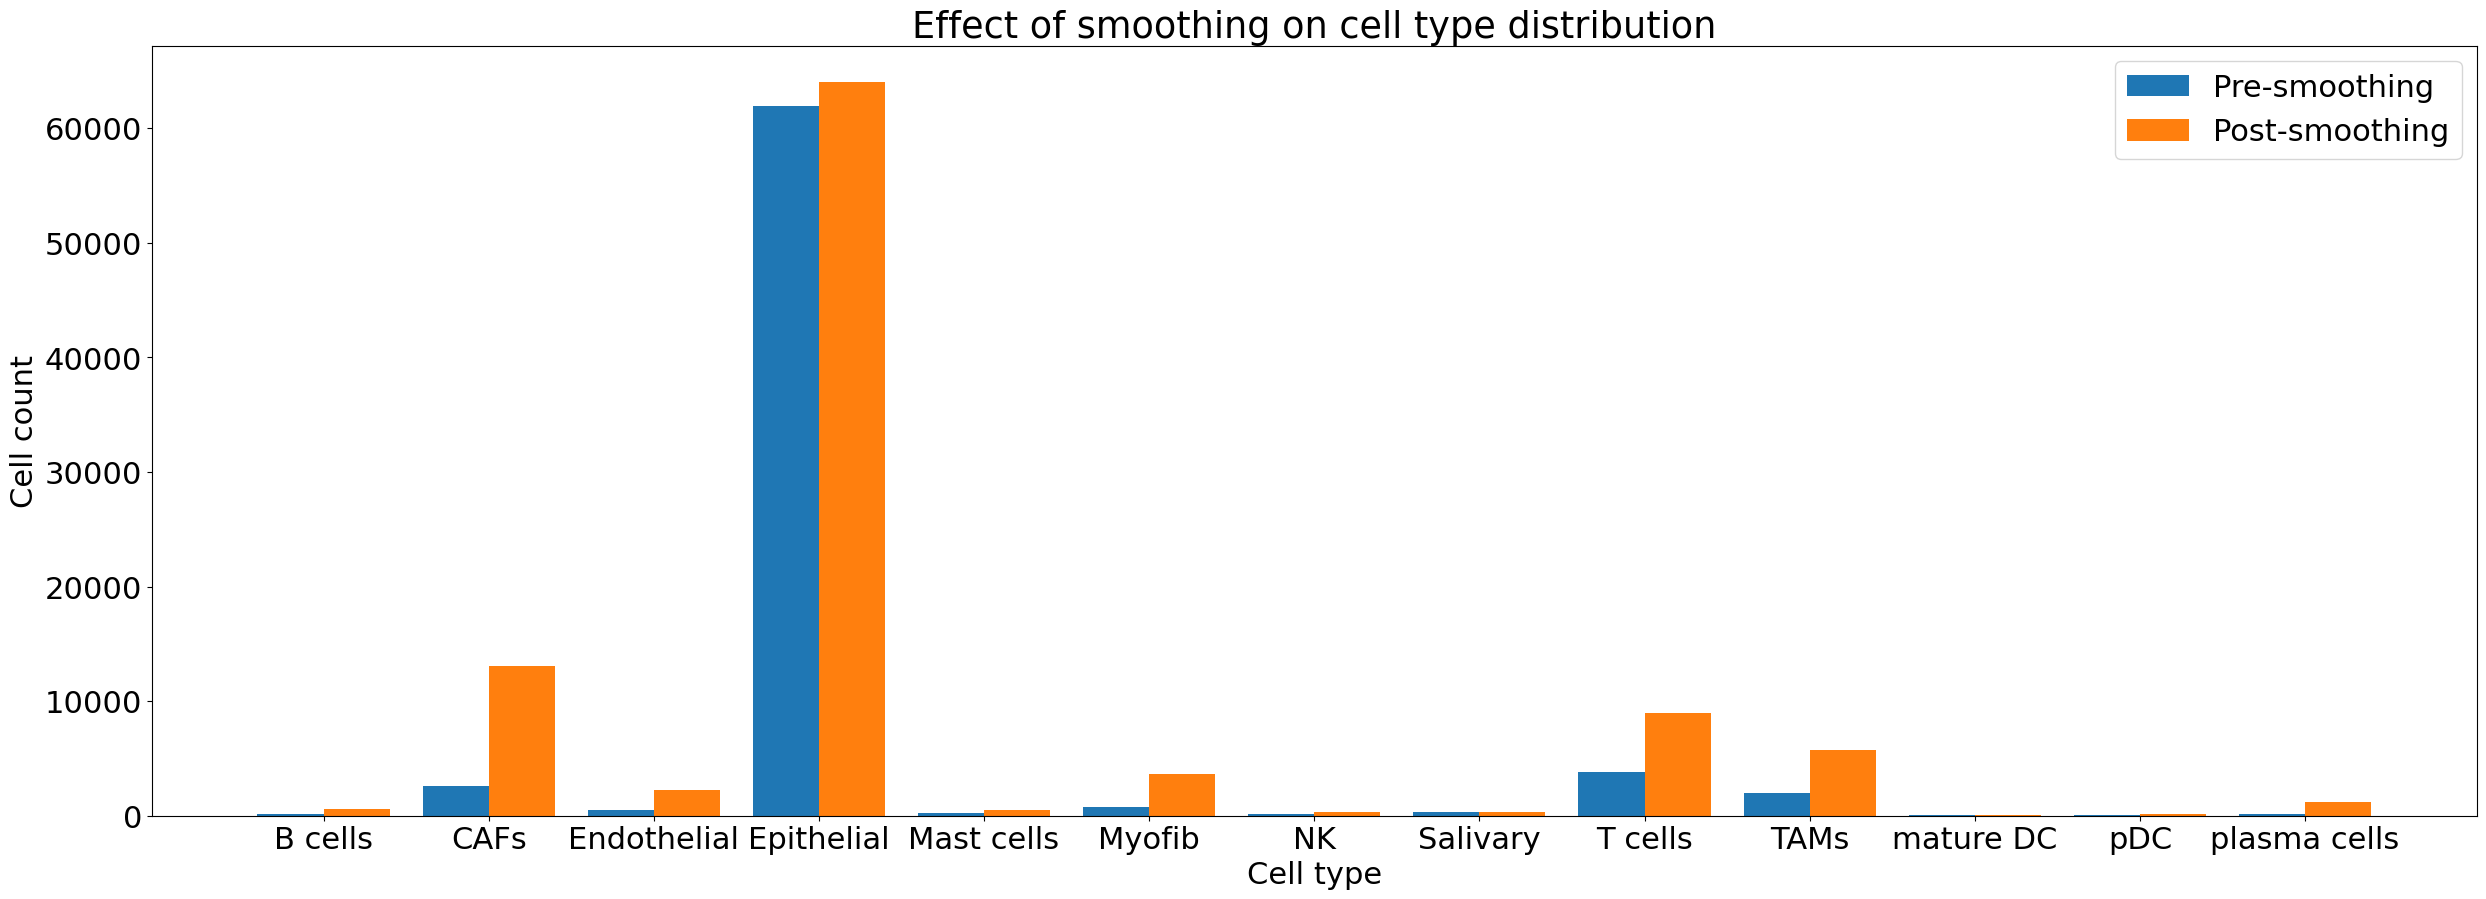

In [126]:
# merged into one plot
original_tumor_region_cell_types = original_tumor_region_cells['PredictedID']
original_tumor_region_keys, original_tumor_region_counts = np.unique(original_tumor_region_cell_types, return_counts=True)

tumor_region_cell_types = tumor_region_cells['PredictedID']
tumor_region_keys, tumor_region_counts = np.unique(tumor_region_cell_types, return_counts=True)

X_axis = np.arange(len(original_tumor_region_keys)) 

plt.figure(figsize=(30,10))
plt.bar(X_axis - 0.2, original_tumor_region_counts, 0.4, label = 'Pre-smoothing') 
plt.bar(X_axis + 0.2, tumor_region_counts, 0.4, label = 'Post-smoothing') 

plt.xticks(X_axis, original_tumor_region_keys)
plt.xlabel("Cell type") 
plt.ylabel("Cell count") 
plt.title("Effect of smoothing on cell type distribution") 
plt.legend()
plt.show() 

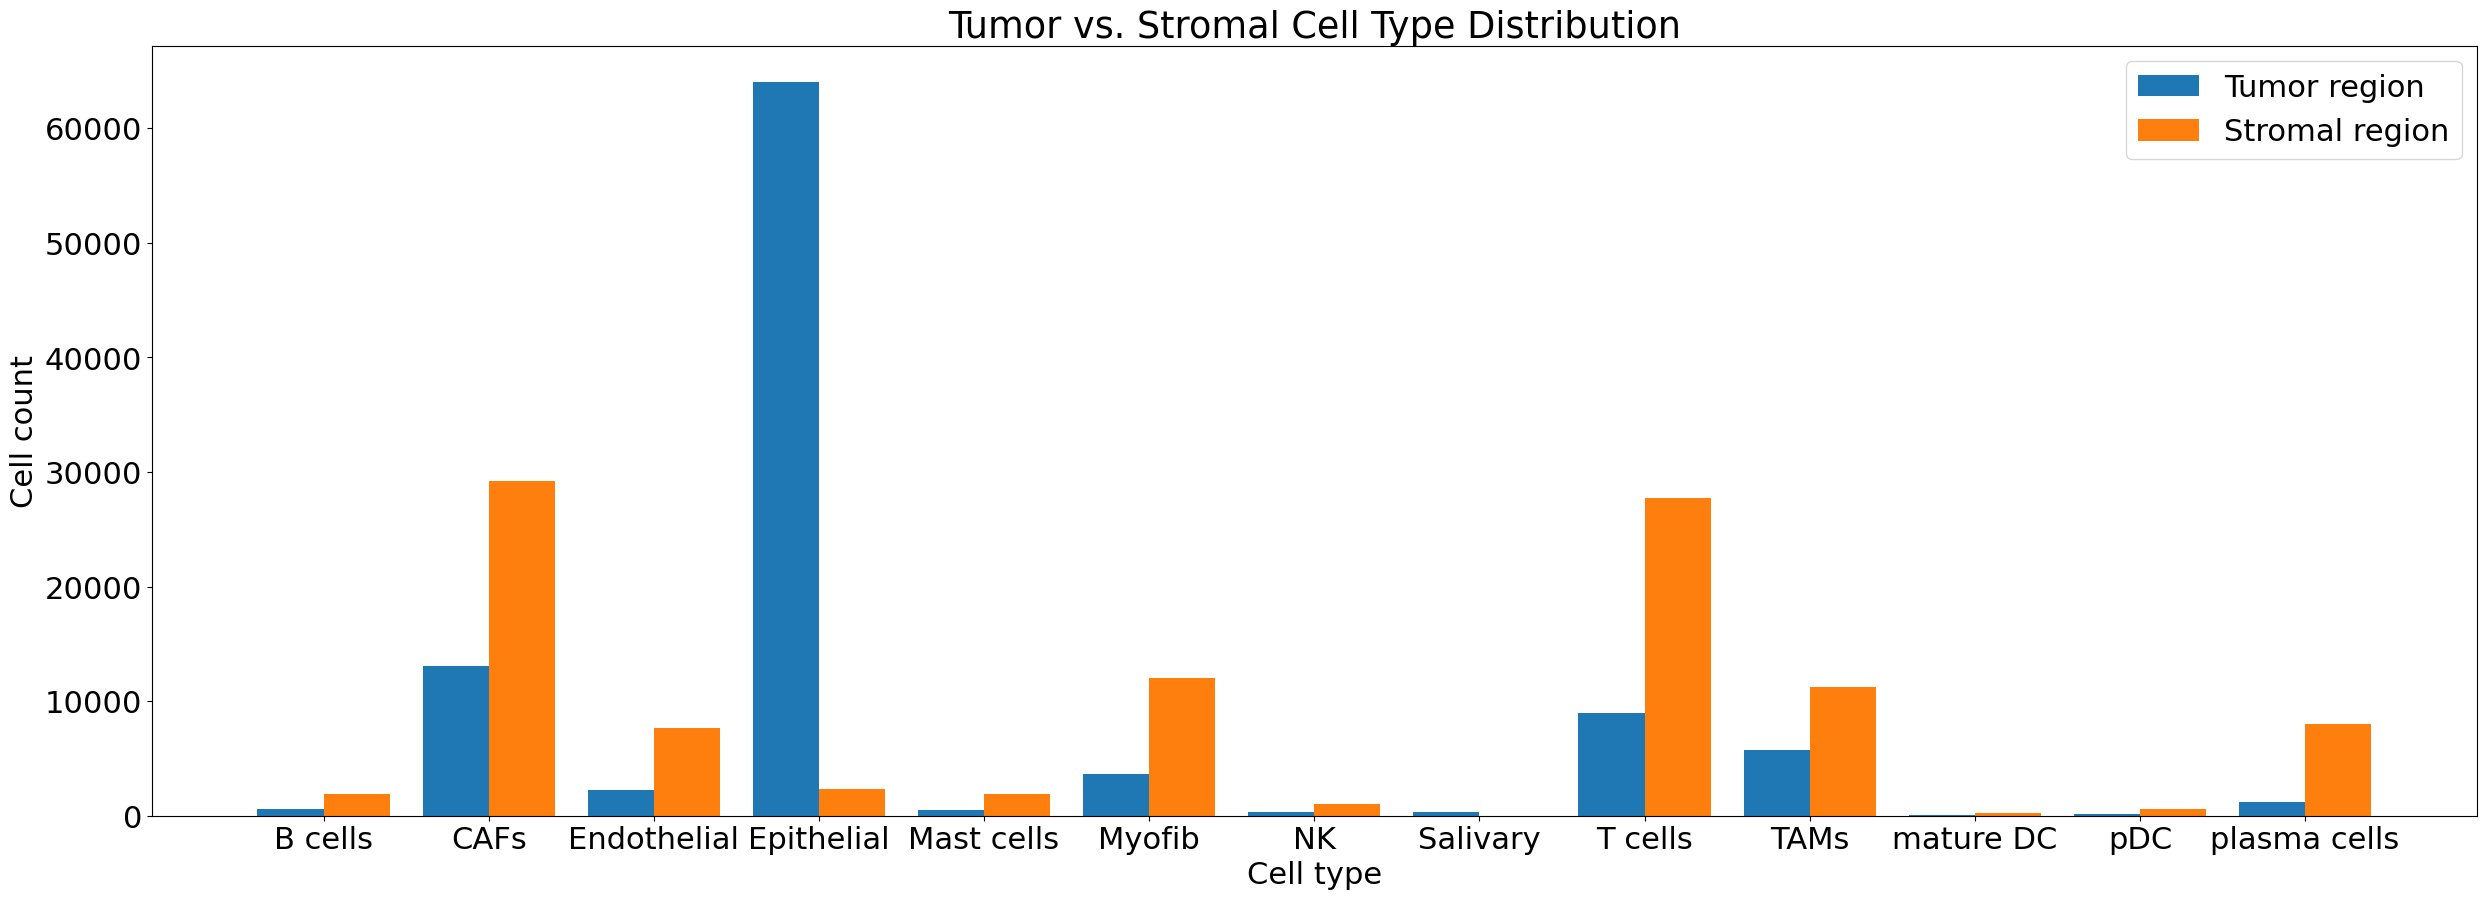

In [127]:
# merged into one plot
tumor_region_cell_types = tumor_region_cells['PredictedID']
tumor_region_keys, tumor_region_counts = np.unique(tumor_region_cell_types, return_counts=True)

stromal_region_cell_types = stromal_region_cells['PredictedID']
stromal_region_keys, stromal_region_counts = np.unique(stromal_region_cell_types, return_counts=True)

X_axis = np.arange(len(tumor_region_keys)) 

plt.figure(figsize=(30,10))
plt.bar(X_axis - 0.2, tumor_region_counts, 0.4, label = 'Tumor region') 
plt.bar(X_axis + 0.2, stromal_region_counts, 0.4, label = 'Stromal region') 

plt.xticks(X_axis, tumor_region_keys)
plt.xlabel("Cell type") 
plt.ylabel("Cell count") 
plt.title("Tumor vs. Stromal Cell Type Distribution") 
plt.legend()
plt.show()

# Inspect tumor/stroma composition over tumor progression

In [179]:
tumor_data = adata.obs[adata.obs['Tumor_region'] == True]
stromal_data = adata.obs[adata.obs['Tumor_region'] == False]

In [181]:
T1_cells = tumor_data[tumor_data['Stage'] == 'T1']
T2_cells = tumor_data[tumor_data['Stage'] == 'T2']
T3_cells = tumor_data[tumor_data['Stage'] == 'T3']
T4_cells = tumor_data[tumor_data['Stage'] == 'T4']

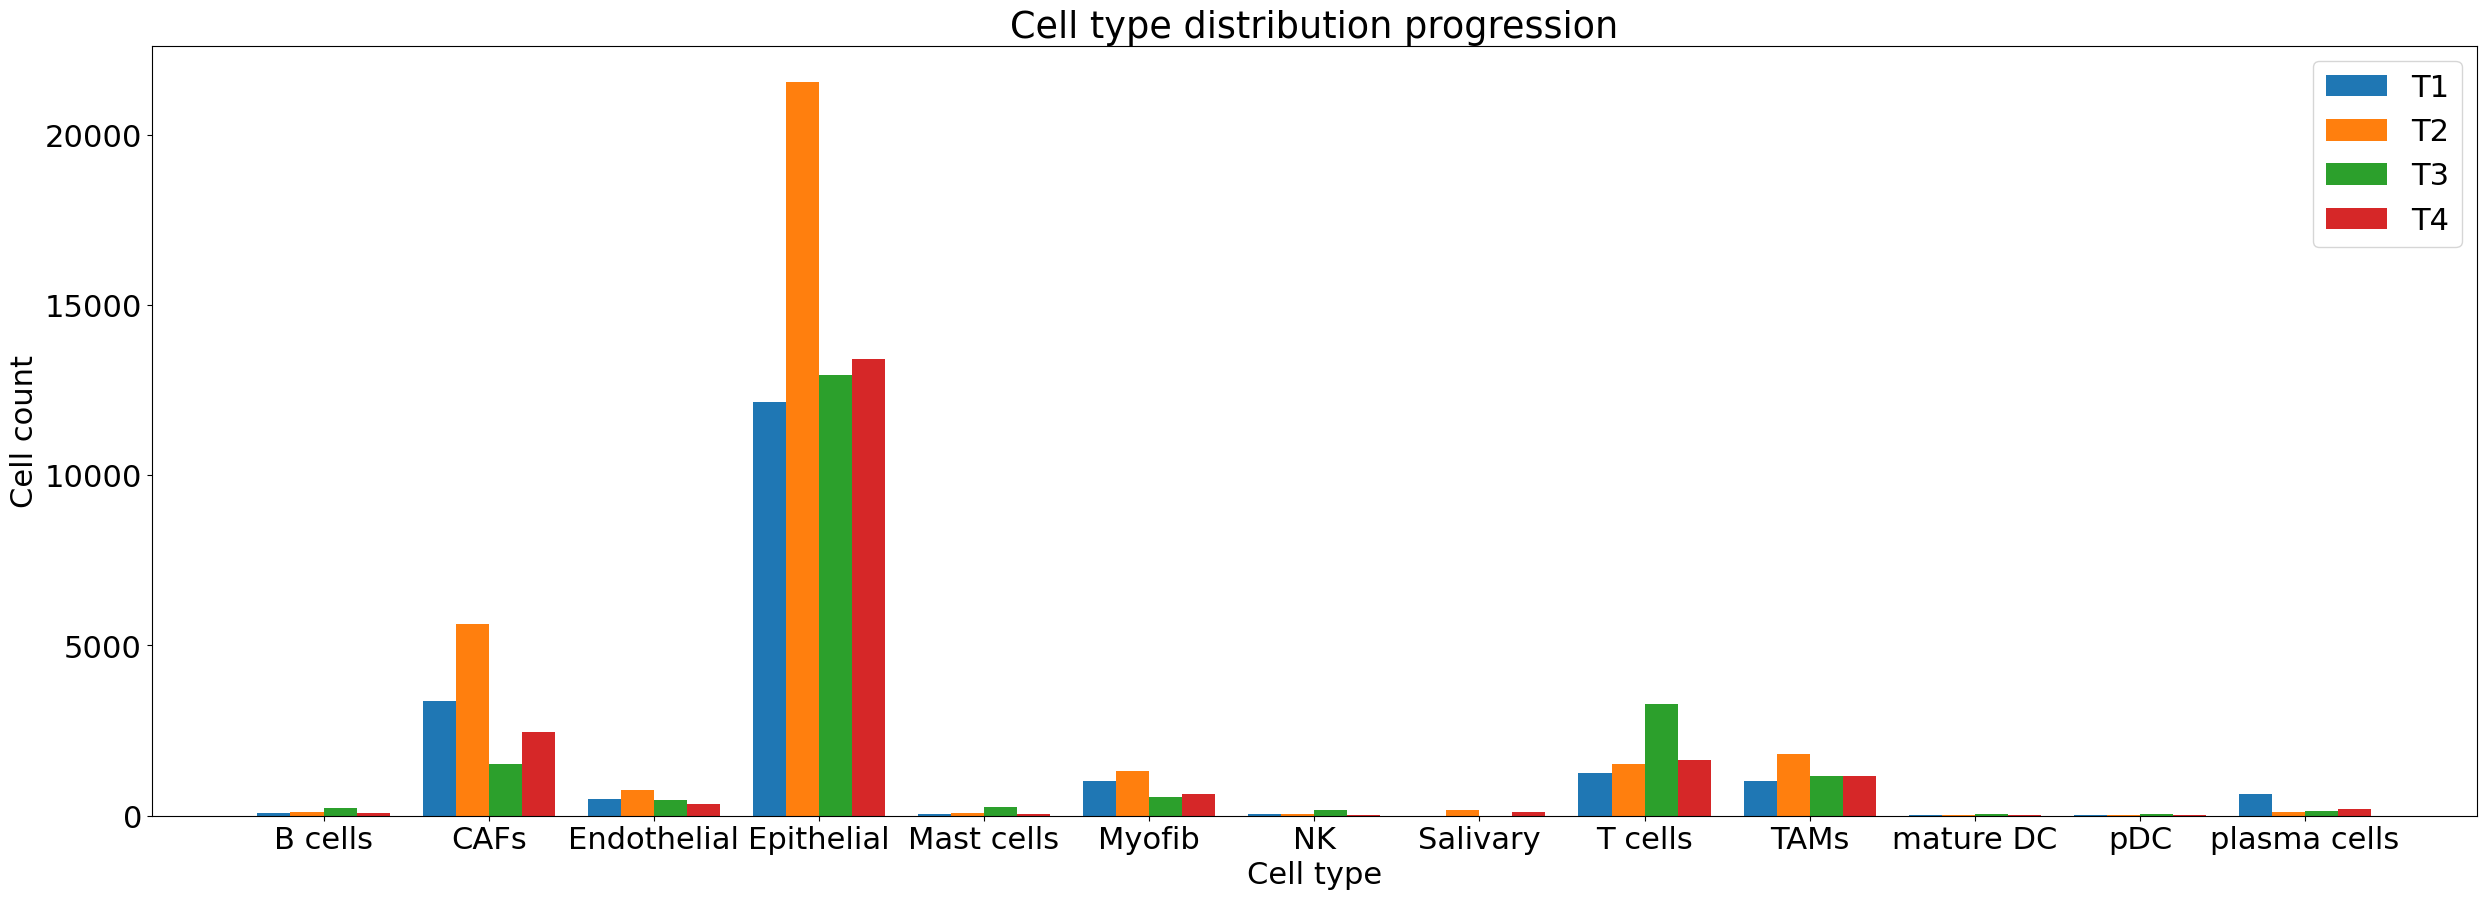

In [182]:
T1_cell_types = T1_cells['PredictedID']
T1_keys, T1_counts = np.unique(T1_cell_types, return_counts=True)
T1_counts = np.insert(T1_counts, 7, 0)

T2_cell_types = T2_cells['PredictedID']
T2_keys, T2_counts = np.unique(T2_cell_types, return_counts=True)

T3_cell_types = T3_cells['PredictedID']
T3_keys, T3_counts = np.unique(T3_cell_types, return_counts=True)

T4_cell_types = T4_cells['PredictedID']
T4_keys, T4_counts = np.unique(T4_cell_types, return_counts=True)

X_axis = np.arange(len(T2_keys))

plt.figure(figsize=(30,10))
plt.bar(X_axis - 0.3, T1_counts, 0.2, label = 'T1')
plt.bar(X_axis - 0.1, T2_counts, 0.2, label = 'T2') 
plt.bar(X_axis + 0.1, T3_counts, 0.2, label = 'T3')
plt.bar(X_axis + 0.3, T4_counts, 0.2, label = 'T4') 

plt.xticks(X_axis, tumor_region_keys)
plt.xlabel("Cell type") 
plt.ylabel("Cell count") 
plt.title("Cell type distribution progression") 
plt.legend()
plt.show()

In [183]:
T1_cells = stromal_data[stromal_data['Stage'] == 'T1']
T2_cells = stromal_data[stromal_data['Stage'] == 'T2']
T3_cells = stromal_data[stromal_data['Stage'] == 'T3']
T4_cells = stromal_data[stromal_data['Stage'] == 'T4']

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (13,) and arg 1 with shape (14,).

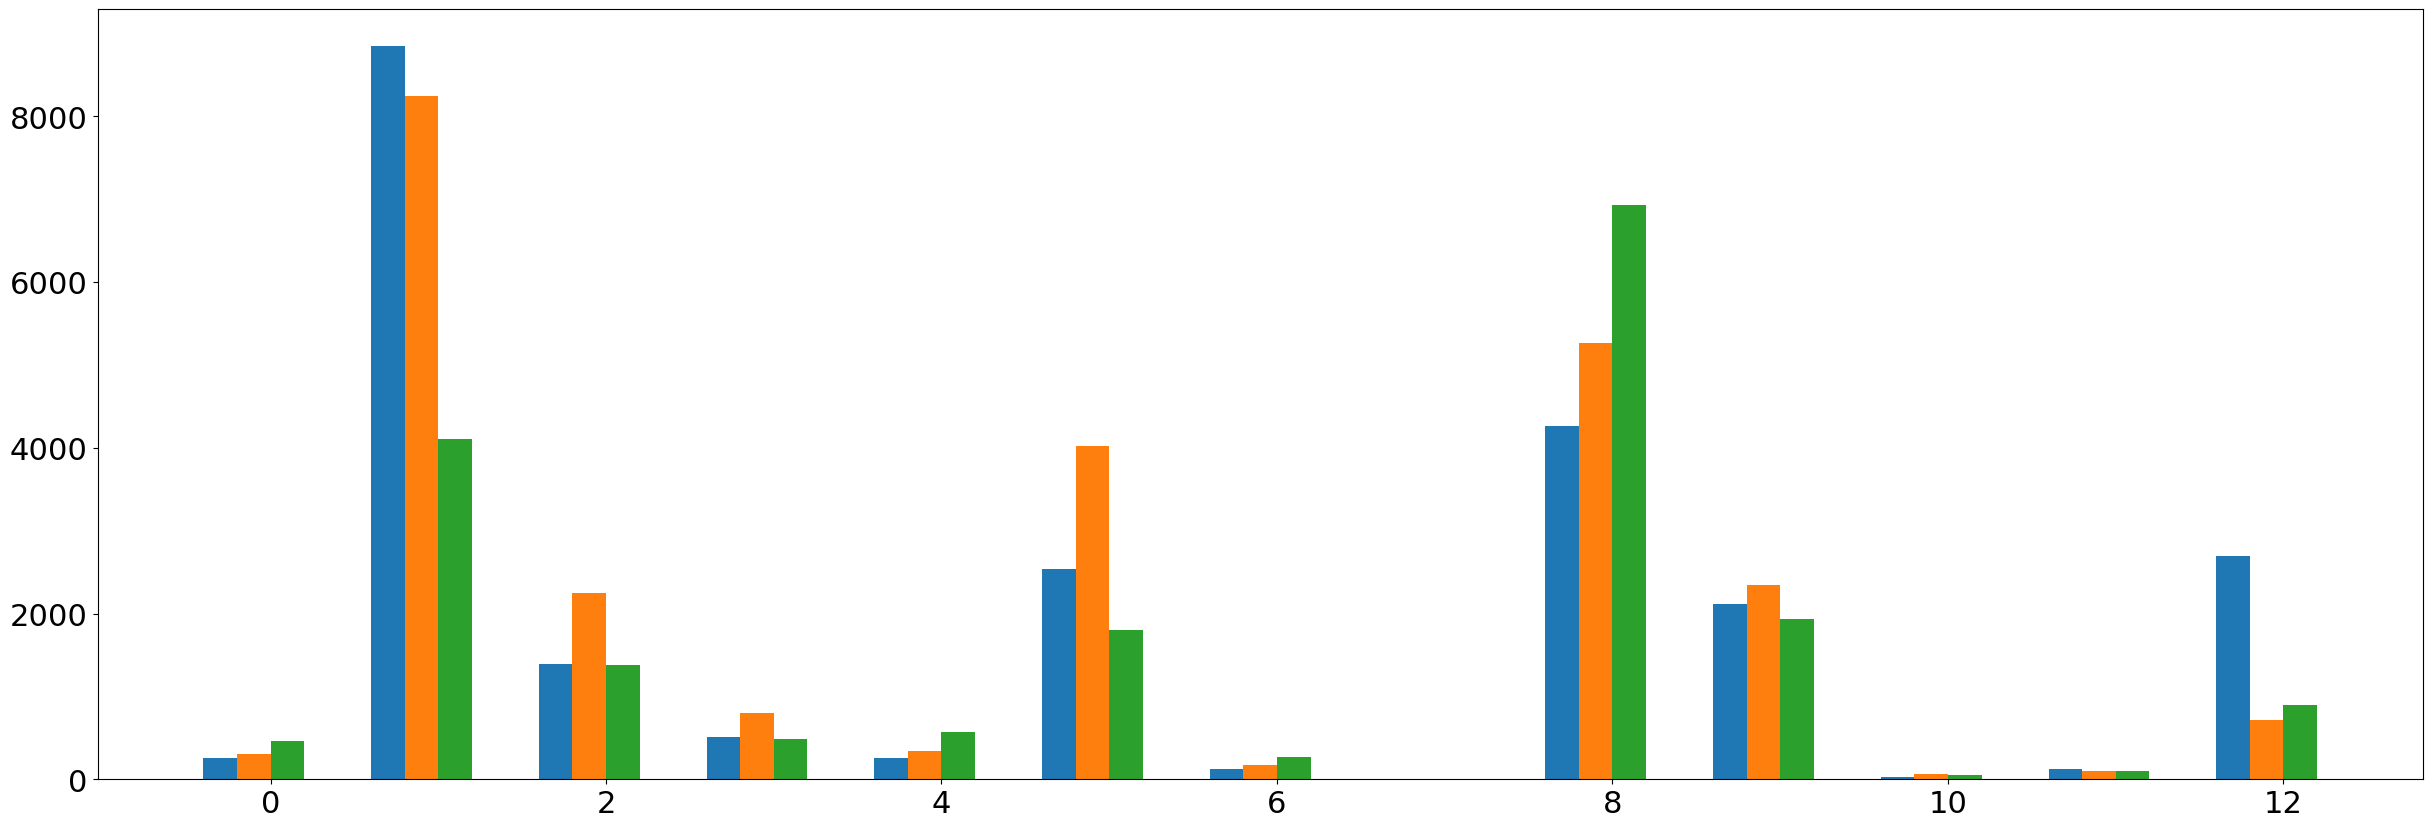

In [194]:
T1_cell_types = T1_cells['PredictedID']
T1_keys, T1_counts = np.unique(T1_cell_types, return_counts=True)
T1_counts = np.insert(T1_counts, 7, 0)

T2_cell_types = T2_cells['PredictedID']
T2_keys, T2_counts = np.unique(T2_cell_types, return_counts=True)
T2_counts = np.insert(T2_counts, 7, 0)

T3_cell_types = T3_cells['PredictedID']
T3_keys, T3_counts = np.unique(T3_cell_types, return_counts=True)

T4_cell_types = T4_cells['PredictedID']
T4_keys, T4_counts = np.unique(T4_cell_types, return_counts=True)
T4_counts = np.insert(T4_counts, 7, 0)

X_axis = np.arange(len(T3_keys))

plt.figure(figsize=(30,10))
plt.bar(X_axis - 0.3, T1_counts, 0.2, label = 'T1')
plt.bar(X_axis - 0.1, T2_counts, 0.2, label = 'T2') 
plt.bar(X_axis + 0.1, T3_counts, 0.2, label = 'T3')
plt.bar(X_axis + 0.3, T4_counts, 0.2, label = 'T4') 

plt.xticks(X_axis, tumor_region_keys)
plt.xlabel("Cell type") 
plt.ylabel("Cell count") 
plt.title("Cell type distribution progression") 
plt.legend()
plt.show()

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

N = 3
ind = np.arange(N) 
width = 0.25

xvals = [8, 9, 2]
bar1 = plt.bar(ind, xvals, width, color = 'r') 

yvals = [10, 20, 30] 
bar2 = plt.bar(ind+width, yvals, width, color='g') 

zvals = [11, 12, 13] 
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b') 

plt.xlabel("Dates") 
plt.ylabel('Scores') 
plt.title("Players Score") 

plt.xticks(ind+width,['2021Feb01', '2021Feb02', '2021Feb03']) 
plt.legend( (bar1, bar2, bar3), ('Player1', 'Player2', 'Player3') ) 
plt.show() 